In [1]:
# built-ins
from pathlib import Path

# third party import
import cv2
import fiftyone as fo
import fiftyone.brain as fob
from PIL import Image
from matplotlib import pyplot as plt

# custom import
from src.data.dataset import get_dataset, merge_datasets

# Load dataset (COCO format)

We merge train and val as train set in this task

In [2]:
datasets = []
for split in ['train', 'valid']:
    dataset_root = Path(f'data/{split}')
    annotation_fp = dataset_root / '_annotations.coco.json'
    dataset = get_dataset(dataset_root, annotation_fp)
    datasets.append(dataset)
train_dataset = merge_datasets(datasets)

dataset_root = Path(f'data/{"test"}')
annotation_fp = dataset_root / '_annotations.coco.json'
test_dataset = get_dataset(dataset_root, annotation_fp)


 100% |█████████████████| 360/360 [4.1s elapsed, 0s remaining, 87.8 samples/s]      
 100% |█████████████████| 101/101 [1.3s elapsed, 0s remaining, 77.7 samples/s]         
 100% |███████████████████| 51/51 [1.2s elapsed, 0s remaining, 44.2 samples/s]      


### Parse scene labels from json files

In [3]:
import json
def parse_user_tags(json_fp: Path) -> dict:
    # Read the JSON file
    with open(json_fp, 'r') as f:
        data = json.load(f)

    # Initialize a dictionary to store image IDs and corresponding user_tags
    image_user_tags_dict = {}

    # Iterate over the images
    for image in data['images']:
        image_id = image['file_name'].split('.')[2]
        user_tags = image.get('extra', {}).get('user_tags', [])
        image_user_tags_dict[image_id] = user_tags

    return image_user_tags_dict

train_tags = parse_user_tags(Path('data/train/_annotations.coco.json'))
valid_tags = parse_user_tags(Path('data/valid/_annotations.coco.json'))
test_tags = parse_user_tags(Path('data/test/_annotations.coco.json'))

# combine the tags
combined_tags = {**train_tags, **valid_tags, **test_tags}

### Add the parsed scene labels to the dataset

In [4]:
# add classification labels to the datasets
error_count = 0
train_dataset_with_tags = train_dataset.clone()
for idx, sample in enumerate(train_dataset_with_tags):
    print(f"Processing idx:{idx}",end="\r")
    unique_id = Path(sample.filepath).stem.split('.')[2]
    try:
        sample["ground_truth"] = fo.Classification(label=combined_tags[unique_id][0])
        sample.save()
    except KeyError:
        error_count += 1
        pass

print(f"Failed to add tags to {error_count} samples")

Failed to add tags to 0 samples


In [5]:
# add classification labels to the datasets
error_count = 0
test_dataset_with_tags = test_dataset.clone()
for idx, sample in enumerate(test_dataset_with_tags):
    print(f"Processing idx:{idx}",end="\r")
    unique_id = Path(sample.filepath).stem.split('.')[2]
    try:
        sample["ground_truth"] = fo.Classification(label=combined_tags[unique_id][0])
        sample.save()
    except KeyError:
        error_count += 1
        pass

print(f"Failed to add tags to {error_count} samples")

Failed to add tags to 0 samples


### Load images as numpy

In [6]:
import cv2
import numpy as np
from numpy import asarray

train_images = []
label_ids = {"living-room":0, "dining-room":1, "bath-room":2, "bed-room":3}
true_labels = []
ground_truth = train_dataset_with_tags.values("ground_truth")
img_path = train_dataset_with_tags.values("filepath")
for idx in range(len(img_path)):
    image = cv2.imread(img_path[idx],0)
    img_normalized = cv2.normalize(image, None, 0, 1.0,
        cv2.NORM_MINMAX, dtype=cv2.CV_32F)  
    img_normalized_resize = cv2.resize(img_normalized, (225, 225))
    train_images.append(asarray(img_normalized_resize))
    label = ground_truth[idx]['label']
    true_labels.append(label_ids[label])

train_images = np.array(train_images)
train_labels = np.array(true_labels)

In [7]:
test_images = []
test_true_labels = []
ground_truth = test_dataset_with_tags.values("ground_truth")
img_path = test_dataset_with_tags.values("filepath")
for idx in range(len(img_path)):
    image = cv2.imread(img_path[idx],0)
    img_normalized = cv2.normalize(image, None, 0, 1.0,
        cv2.NORM_MINMAX, dtype=cv2.CV_32F)  
    img_normalized_resize = cv2.resize(img_normalized, (225, 225))
    test_images.append(asarray(img_normalized_resize))
    label = ground_truth[idx]['label']
    test_true_labels.append(label_ids[label])

test_images = np.array(test_images)
test_labels = np.array(test_true_labels)

In [8]:
train_images=  train_images.reshape(train_images.shape[0],-1)
train_images.shape

(461, 50625)

In [9]:
test_images=  test_images.reshape(test_images.shape[0],-1)
test_images.shape

(51, 50625)

### Implement Support Vector Classification

In [10]:
from sklearn import svm
clf = svm.SVC(kernel='linear')
clf = svm.SVC(decision_function_shape='ovo')
clf.fit(train_images, train_labels)


SVC(decision_function_shape='ovo')

Accuracy: 100.00%


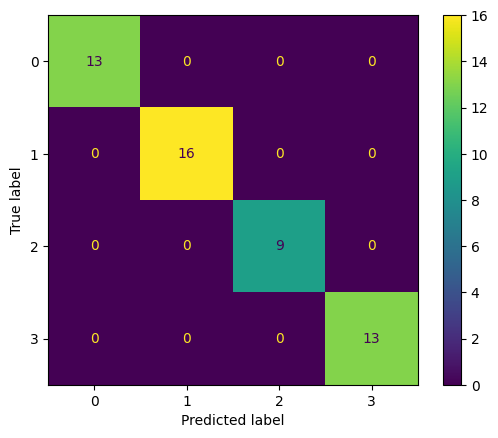

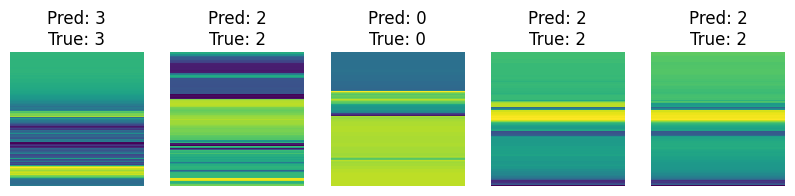

In [14]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
# Predict on the test set
test_predictions = clf.predict(test_images)

# Calculate the accuracy
accuracy = accuracy_score(test_labels, test_predictions)
print(f"Accuracy: {accuracy*100:.2f}%")

# Plot confusion matrix
cm = confusion_matrix(test_labels, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Optionally, display some test images with their predicted labels
fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i, ax in enumerate(axes):
    ax.imshow(cv2.resize(test_images[i], (225, 225))*255, interpolation='none')
    ax.set_title(f"Pred: {test_predictions[i]}\nTrue: {test_labels[i]}")
    ax.axis('off')
plt.show()
